# REINFORCE-improvements
* Noise reduction
* Reward Normalization

---

In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [1]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical


Bad key "text.kerning_factor" on line 4 in
/home/horst/anaconda3/envs/drlnd-4-copy/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### 2. Define the Architecture of the Policy

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
env = gym.make('CartPole-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('MountainCar-v0')
env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)


class Policy(nn.Module):
#     def __init__(self, s_size=4, h_size=16, a_size=2):
    def __init__(self, h_size=16):
        super(Policy, self).__init__()
        s_size = env.observation_space.shape[0]
#         a_size = env.action_space.shape[0]  # for continuous action spaces
        a_size = env.action_space.n    # for discrete action spaces
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # return a tensor containing the probabilities of each action
        return F.softmax(x, dim=1)
#         return x.cpu().data

    
    def act(self, state):
        # transform the state to a torch tensor and send it to device (GPU or CPU) 
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # compute the action probabilities -> do the rest of the calculation on CPU
        probs = self.forward(state).cpu()
        # Create a categorical distribution parameterized by probs
        m = Categorical(probs)
        # sample according to the underlying probability
        action = m.sample()
        # return the action item and the log of the underlying probability!
        return action.item(), m.log_prob(action)

observation space: Box(4,)
action space: Discrete(2)


### 3. Train the Agent with the improved REINFORCE method

Add **noise reduction** by sampling a number of trajectories and estimate the policy gradient by averaging across all these different trajectories:
$$ ĝ = \frac{1}{N}  \sum_{i=1}^{N} R_i \sum_{t} \nabla_\theta log \pi_\theta(a_{t}^{(i)} | s_{t}^{(i)})$$
<br>
Add **reward normalization** by using the multiple trajectories:
$$ \mu = \frac{1}{N} \sum_{i=1}^{N}R_i $$
<br>
$$ \sigma = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (R_i - \mu)^2} $$
<br>
$$ R_i \leftarrow \frac{R_i - \mu}{\sigma}$$
Where $N$ is the number of trajectories.

In [4]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=3000, max_t=1000, gamma=1.0, print_every=100):
    # save the last 100 scores within a double-ended-queue 
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        # run n_trajectories trajectories
        n_trajectories = 5
        trajectory_reward = []
        trajectory_log_probs = []
        trajectory_loss = []
        reward_mu = 0
        reward_sigma = 0
        
        # collect n_trajectories trajectories
        for i_trajectory in range(n_trajectories):
            saved_log_probs = []
            rewards = []
            # reset the state
            state = env.reset()
            for t in range(max_t):
                # get the next action (item) and the log of its underlying probability
                action, log_prob = policy.act(state)
                # store the log of the underlying probability!
                saved_log_probs.append(log_prob)
                # do the next step in the environment according to the action
                state, reward, done, _ = env.step(action)
                # store the reward
                rewards.append(reward)
                if done:
                    break
            # sum up the rewards of the trajectory and store it in the double-ended-queue
            scores_deque.append(sum(rewards))
             # sum up the rewards of the trajectory and store it
            scores.append(sum(rewards))

            # calculate the discount factor
            discounts = [gamma**i for i in range(len(rewards)+1)]
            # cumpute the total reward of the trajectory (discount * reword) = R(tau^i_episode)
            R = sum([a*b for a,b in zip(discounts, rewards)])
            
            # store the reward of the trajectory
            trajectory_reward.append(R)
            # store the log probabilities of each time step of the trajectory
            trajectory_log_probs.append(saved_log_probs)
        
        # compute mu for the normalized reward
        reward_mu = sum(trajectory_reward) / n_trajectories
        
        # compute sigma for the normalized reward
        tt = []
        for r in trajectory_reward:
            tt.append((r - reward_mu)**2)
        
        reward_sigma = np.sqrt(sum(tt) / n_trajectories)
#         if(reward_sigma == 0):
#             print(reward_sigma)
        
        # compute the normalized reward
        R_normalized = []
        for r in trajectory_reward:
            if reward_sigma > 0:
                R_normalized.append((r-reward_mu) / reward_sigma)
            else:
                R_normalized.append(reward_mu)
        
        # compute the policy-loss 
        for i, log_probs in enumerate(trajectory_log_probs):
            policy_loss = []
            for log_prob in log_probs:
                policy_loss.append(-log_prob * R_normalized[i])
            trajectory_loss.append(torch.cat(policy_loss).sum())
        
        trajectory_policy_loss = sum(trajectory_loss) / n_trajectories        

        # reset the gradints to zero (because they are accumulated)
        optimizer.zero_grad()
        # compute the gradiants = ĝ => U(theta)
        trajectory_policy_loss.backward()
        # do the weight updates => theta = theta + lr * ĝ
        optimizer.step()

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            break
        
    return scores
    
scores = reinforce()

Episode 100	Average Score: 66.49
Episode 200	Average Score: 79.61
Episode 300	Average Score: 192.98
Environment solved in 302 episodes!	Average Score: 196.22


### 4. Plot the Scores

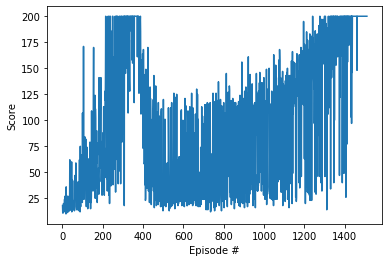

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In [6]:
import time

# env = gym.make('CartPole-v0')
# env = gym.make('MountainCar-v0')

state = env.reset()
for t in range(1000):
    action, _ = policy.act(state)
    env.render()
    time.sleep(0.02)
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()